<a href="https://colab.research.google.com/github/kolla118/KOLLA_INFO5731_Spring2020-/blob/main/In_class_exercise_04_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The fourth in-class-exercise (40 points in total, 03/29/2022)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (10 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [3]:
# Getting all the imports

# Run in python console
import nltk; nltk.download('stopwords')


import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

!pip install pyLDAvis

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)






[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 1.7 MB 8.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=72a8c309bf605ffb38fa297c351480f4f5a294ae4e58b9a089cab4a0b00a5f22
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [4]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


In [6]:
df = pd.read_csv('iphone_reviews .csv')
df.dropna(how='any', inplace=True)
print(df.Reviews)
df.head()

0                              Katherine1.0 out of 5 stars
1                                       Not FULLY Unlocked
2        Reviewed in the United States on February 13, ...
4          Purchased this product advertised as fully u...
7                            432 people found this helpful
                               ...                        
58983                  Buen producto en buenas condiciones
58984    Reviewed in Mexico on January 15, 2021Size: 12...
58986                                        Buen producto
58990                                         Report abuse
58991                          Translate review to English
Name: Reviews, Length: 25489, dtype: object


,Reviews
0,Katherine1.0 out of 5 stars
1,Not FULLY Unlocked
2,"Reviewed in the United States on February 13, ..."
4,Purchased this product advertised as fully u...
7,432 people found this helpful


In [7]:
# Convert to list
data = df.Reviews.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Katherine1.0 out of 5 stars']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['katherine', 'out', 'of', 'stars']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['katherine', 'out', 'of', 'stars']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['star']]


In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1)]]


In [18]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.134*"new" + 0.103*"could" + 0.077*"phone" + 0.055*"brand" + 0.047*"worth" '
  '+ 0.041*"cheap" + 0.039*"amazing" + 0.020*"satisfecho" + '
  '0.019*"especificacion" + 0.016*"defectuoso"'),
 (1,
  '0.083*"happy" + 0.058*"time" + 0.056*"go" + 0.047*"price" + '
  '0.033*"refurbish" + 0.032*"phone" + 0.023*"feel" + 0.023*"bueno" + '
  '0.019*"muy" + 0.018*"increible"'),
 (2,
  '0.179*"phone" + 0.128*"come" + 0.067*"renew" + 0.058*"original" + '
  '0.040*"accesorio" + 0.032*"charger" + 0.028*"return" + 0.025*"health" + '
  '0.021*"definitely" + 0.019*"even"'),
 (3,
  '0.314*"show" + 0.295*"comment" + 0.021*"foto" + 0.016*"indicada" + '
  '0.015*"conveinence" + 0.015*"aceptable" + 0.013*"gracia" + 0.012*"comprare" '
  '+ 0.012*"sino" + 0.011*"esperable"'),
 (4,
  '0.485*"report" + 0.485*"abuse" + 0.000*"fixable" + 0.000*"adhesive" + '
  '0.000*"sanitized" + 0.000*"smell" + 0.000*"vertical" + 0.000*"sort" + '
  '0.000*"prepare" + 0.000*"portion"'),
 (5,
  '0.072*"really" + 0.065*"get

In [20]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [21]:
!apt install unzip
!mkdir my
!unzip -q drive/MyDrive/mallet-2.0.8.zip -d my


Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [22]:
mallet_path = '/content/my/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [23]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('loading', 0.28844089228199926),
   ('problem', 0.2849815101992127),
   ('star', 0.25969223428366933),
   ('comment', 0.08111654538947871),
   ('customer', 0.021233448646069426),
   ('amazon', 0.014672551592508649),
   ('translate', 0.0021472026720744364),
   ('descripcion', 0.001192890373374687),
   ('brown', 0.0007157342240248121),
   ('cristian', 0.0007157342240248121)]),
 (1,
  [('purchase', 0.16783905458638154),
   ('review', 0.1606640405177265),
   ('function', 0.12099043331457512),
   ('grade', 0.10607765897580192),
   ('unlockedproduct', 0.08961733258300507),
   ('renewedverifie', 0.08821046707934721),
   ('controller', 0.07709622960045019),
   ('true', 0.04051772650534609),
   ('datum', 0.01730444569499156),
   ('product', 0.008581879572312887)]),
 (2,
  [('great', 0.10135984458918981),
   ('good', 0.08513312764255514),
   ('phone', 0.07781967775111416),
   ('work', 0.07530567935093133),
   ('love', 0.05222260313107074),
   ('condition', 0.04068106502114044),
   ('buy

In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

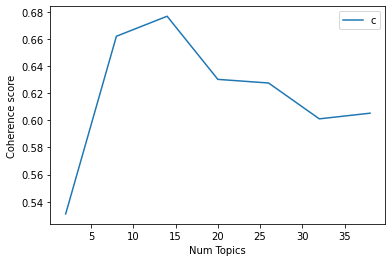

In [25]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5311
Num Topics = 8  has Coherence Value of 0.662
Num Topics = 14  has Coherence Value of 0.6767
Num Topics = 20  has Coherence Value of 0.6302
Num Topics = 26  has Coherence Value of 0.6275
Num Topics = 32  has Coherence Value of 0.6011
Num Topics = 38  has Coherence Value of 0.6053


In [30]:
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.175*"function" + 0.169*"comment" + 0.140*"star" + 0.111*"controller" + '
  '0.099*"problem" + 0.081*"loading" + 0.059*"true" + 0.025*"datum" + '
  '0.009*"rayone" + 0.006*"pero"'),
 (1,
  '0.153*"review" + 0.151*"provider" + 0.144*"purchase" + 0.143*"grade" + '
  '0.133*"renewedverifie" + 0.121*"unlockedproduct" + 0.074*"size" + '
  '0.049*"purpleservice" + 0.005*"mobileproduct" + 0.001*"terribly"'),
 (2,
  '0.226*"phone" + 0.152*"work" + 0.079*"love" + 0.039*"day" + 0.027*"brand" + '
  '0.027*"issue" + 0.026*"fine" + 0.020*"nice" + 0.020*"month" + '
  '0.019*"unlocked"'),
 (3,
  '0.088*"screen" + 0.078*"phone" + 0.062*"scratch" + 0.028*"protector" + '
  '0.026*"camera" + 0.023*"iphone" + 0.018*"thing" + 0.018*"apple" + '
  '0.015*"crack" + 0.014*"device"'),
 (4,
  '0.290*"problem" + 0.259*"loading" + 0.225*"star" + 0.167*"comment" + '
  '0.001*"ashley" + 0.001*"brown" + 0.001*"alicia" + 0.001*"cristian" + '
  '0.001*"anthony" + 0.001*"brandon"'),
 (5,
  '0.266*"image" + 0.18

In [31]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.0787,"problem, loading, star, comment, ashley, brown...",Katherine1.0 out of 5 stars
1,1,0.0,0.0714,"function, comment, star, controller, problem, ...",Not FULLY Unlocked
2,2,1.0,0.1054,"review, provider, purchase, grade, renewedveri...","Reviewed in the United States on February 13, ..."
3,3,2.0,0.1304,"phone, work, love, day, brand, issue, fine, ni...",Purchased this product advertised as fully un...
4,4,7.0,0.1240,"helpful, find, person, people, golpe, opcion, ...",432 people found this helpful
5,5,7.0,0.0896,"helpful, find, person, people, golpe, opcion, ...",Helpful
6,6,10.0,0.1071,"report, abuse, hora, tear, girl, ronald, iffy,...",Report abuse
7,7,6.0,0.1007,"show, comment, excelentes_condicione, alexis, ...",Showing 0 comments
8,8,4.0,0.0949,"problem, loading, star, comment, ashley, brown...",There was a problem loading comments right now...
9,9,8.0,0.0904,"great, battery, condition, good, life, perfect...","NOT EXPECTED, GREAT PURCHASE!"


In [32]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1915,"function, comment, star, controller, problem, ...",Al principio tenía muchas dudas sobre comprar...
1,1.0,0.1420,"review, provider, purchase, grade, renewedveri...","Reviewed in the United States on September 25,..."
2,2.0,0.3125,"phone, work, love, day, brand, issue, fine, ni...",I got this phone earlier than the estimated t...
3,3.0,0.4399,"screen, phone, scratch, protector, camera, iph...","I bought mine from Metro, so my only choices ..."
4,4.0,0.1431,"problem, loading, star, comment, ashley, brown...",There was a problem loading comments right now...


In [33]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,4.0,"problem, loading, star, comment, ashley, brown...",5431.0,0.2131
1.0,0.0,"function, comment, star, controller, problem, ...",1119.0,0.0439
2.0,1.0,"review, provider, purchase, grade, renewedveri...",1046.0,0.0410
3.0,2.0,"phone, work, love, day, brand, issue, fine, ni...",669.0,0.0262
4.0,7.0,"helpful, find, person, people, golpe, opcion, ...",2536.0,0.0995
...,...,...,...,...
25484.0,0.0,"function, comment, star, controller, problem, ...",NaN,NaN
25485.0,13.0,"review, renewedverifie, purchase, unlockedprod...",NaN,NaN
25486.0,0.0,"function, comment, star, controller, problem, ...",NaN,NaN
25487.0,10.0,"report, abuse, hora, tear, girl, ronald, iffy,...",NaN,NaN


## (2) (10 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [27]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [34]:
def prepare_corpus(doc_clean):
   
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix


In [35]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    #number_of_topics = 20
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=20, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [36]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    #number_of_topics = 7
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=20, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [37]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    #number_of_topics = 7
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

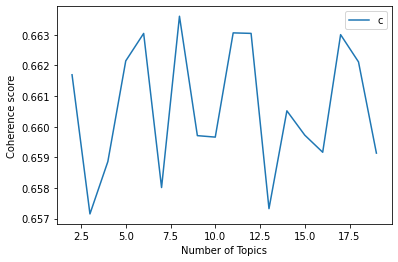

In [38]:
start,stop,step=2,20,1
plot_graph(data_lemmatized,start,stop,step)

In [39]:
number_of_topics=13
words=10
model=create_gensim_lsa_model(data_lemmatized,number_of_topics,words)

[(0, '0.406*"purchase" + 0.396*"grade" + 0.395*"review" + 0.390*"renewedverifie" + 0.383*"provider" + 0.360*"unlockedproduct" + 0.244*"size" + 0.097*"purpleservice" + 0.084*"phone" + 0.050*"redservice"'), (1, '0.442*"comment" + 0.374*"problem" + 0.372*"try" + 0.371*"right" + 0.368*"later" + 0.367*"loading" + 0.306*"star" + 0.077*"show" + 0.070*"phone" + -0.044*"grade"'), (2, '-0.813*"phone" + -0.183*"come" + -0.148*"work" + -0.141*"new" + -0.131*"buy" + -0.129*"screen" + -0.124*"battery" + -0.122*"get" + -0.109*"great" + -0.103*"good"'), (3, '0.950*"image" + 0.310*"com" + 0.014*"medium" + 0.012*"https" + 0.003*"gexo" + 0.003*"skfp" + 0.002*"hfjt" + 0.002*"ad" + 0.002*"efrmruhys" + 0.002*"tgprq"'), (4, '-0.708*"report" + -0.706*"abuse" + 0.004*"phone" + 0.002*"come" + 0.001*"battery" + 0.001*"work" + 0.001*"new" + -0.001*"steal" + 0.001*"good" + 0.001*"get"'), (5, '-0.729*"show" + -0.583*"comment" + 0.160*"star" + 0.147*"problem" + 0.145*"try" + 0.143*"right" + 0.141*"later" + 0.141*"lo

## (3) (10 points) Generate K topics by using  lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [40]:
import pyLDAvis
pyLDAvis.enable_notebook()

In [42]:
!pip install lda2vec
from lda2vec import preprocess, Corpus
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

try:
    import seaborn
except:
    pass

ImportError: ignored

## (4) (10 points) Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [1]:
!pip install bertopic

     |████████████████████████████████| 57 kB 4.0 MB/s 
     |████████████████████████████████| 5.2 MB 11.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 86 kB 7.5 MB/s 
     |████████████████████████████████| 79 kB 10.8 MB/s 
     |████████████████████████████████| 3.8 MB 48.1 MB/s 
     |████████████████████████████████| 1.2 MB 60.3 MB/s 
     |████████████████████████████████| 67 kB 7.1 MB/s 
     |████████████████████████████████| 895 kB 58.1 MB/s 
     |████████████████████████████████| 6.5 MB 36.9 MB/s 
     |████████████████████████████████| 636 kB 58.6 MB/s 
     |████████████████████████████████| 1.1 MB 62.9 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2330802 sha256=4fd3aa813171b5126821bc67ea7ecc5cef0ba3c966a90d190c6e104b0c228b8e
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99e

In [12]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=False, verbose=True)
docs = [str(word) for word in data_lemmatized]
topics, probs = topic_model.fit_transform(docs)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/797 [00:00<?, ?it/s]

2022-04-04 04:39:18,877 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-04-04 04:40:47,533 - BERTopic - Reduced dimensionality with UMAP
2022-04-04 04:40:50,860 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [13]:
freq = topic_model.get_topic_info(); freq.head(10)

,Topic,Count,Name
0,0,3609,0____
1,1,2882,1_abuse_report_lose_child
2,2,2419,2_helpful_ease_friendly_
3,3,2418,3_show_comment_user_
4,-1,1942,-1_phone_come_work_scratch
5,4,958,4_loading_later_right_try
6,5,826,5_star_coss_sky_yas
7,6,758,6_loading_later_right_try
8,7,674,7_size_unlockedproduct_provider_renewedverifie
9,8,611,8_unlockedproduct_provider_renewedverifie_grade


In [14]:
topic_model.get_topic(0)

[('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05)]

## (5) (10 extra points) Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
Out of the 4 topic modeling algorithms, I think LDA would be best suited for creating human readable topics and
 also because it has the highest coherence score, 0.66 compared with 0.5 for LSA which is another human readable model.

Both LDA2VEC and BERTopic models require heavy GPU usage as they are deep learning based models. 
This also means they generate topics that are less understandable by humans.